In [1]:
DATA_DIR = '../../data/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
from itertools import combinations

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Отчет высылается по почте Зуеву Кириллу на адрес kir2207@list.ru

В качестве темы письма указать: «КЛ ДЗ № 1, ФИО»

Срок выполнения задания – до 24 февраля включительно

Замечания:
1. Отчет должен быть в виде текста на русском языке, объемом 1-5 страниц. Код программы присылается отдельным файлом (в комментариях следует указать язык программирования и его версию, а также использованные библиотеки и откуда они взяты).
2. Оценка задания учитывает общий объем и качество проведенной работы, включая полноту тестирования и подробность отчета об исследовании. Автоматическое тестирование обычно оценивается более высоко, чем ручное (при прочих равных).
3. За творческие и более полные решения могут быть добавлены баллы.

# Задание D

Выполнить лексико-статистический анализ двух текстов на русском языке, среднего размера:
1. текст художественной прозы, например, текста главы 2 из книги Л Кэрролла «Алиса в Стране Чудес» или главы из романа Л.Толстого или рассказа А.Чехова.
2. текст научно-технической или деловой прозы.

Для этого следует составить программу, которая с помощью выбранного морфопроцессора,
например: Диалинг-АОТ , mystem, pymorphy или CrossMorphy (ссылки см. в варианте А),
осуществляет морфологический анализ словоформ текста;
вычисляет 7-15 статистических характеристик разного типа:
- общестатистические: общее число словоупотреблений, число различных словоформ, средняя
длина предложения (если процессор разбивает текст на предложения) и т.п.;
- морфологические: абсолютная и относительная частота омонимичных словоформ, процент
разных частей речи, наиболее частотные падежи у существительных и прилагательных,
относительную частоту падежей, наиболее частотные морфологические формы глаголов
(время/лицо/число) и т.п.;
- лексические: количество уникальных лемм, число уникальных лемм разных частей речи
(существительных, глаголов и др.), число незнакомых слов, самые частотные слова и их
относительная частота, самые частотные слова основных частей речи (существительные,
прилагательные, наречия, глаголы), коэффициент лексического богатства текста (=отношение
числа различных лемм к общему числу словоупотреблений) и т.п.
выводит подсчитанные характеристики в удобной, обозримой форме.

Отчет: составленная программа, подсчитанная статистика (в удобной, обозримой форме, в
зависимости от стилей/жанров текстов), пояснения по способу ее подсчета и выводы,
программа с комментариями.

# Выкачиваем данные

## Художественный текст

In [6]:
with open(DATA_DIR+'art_alice_full_text.txt', 'r') as f:
    alice_txt = f.read()

In [7]:
alice_txt_by_chapter = {idx:s.strip() for idx, s in enumerate([s for s in re.split('Глава.*\n\n\n', alice_txt) if len(s)>0])}

## Научно-технический текст

"ПОСОБИЕ ПО НАПИСАНИЮ
РАЗНОГО РОДА ДЕЛОВЫХ ТЕКСТОВ"
https://www.iis.nsk.su/files/articles/sbor_kas_16_nesgovorova.pdf

In [8]:
with open(DATA_DIR+'doc_how_to_business_text.txt','r') as f:
    how_to_buis_txt = f.read()

In [9]:
def beautify_str(s):
    s = s.replace('\n',' ')
    s = re.sub('\ +', ' ', s)
    s = s.replace('т.д.','т_д').replace('т.п.','т_п')
    s = re.sub(r'\d+\.','', s)
    s = re.sub(r'Рис\. \d+\n+', '', s)
    return s

In [10]:
alice_txt_by_chapter = {idx:s for idx,s in alice_txt_by_chapter.items()}
how_to_buis_txt = beautify_str(how_to_buis_txt)

# Ищем статистику с pymorphy и считаем метрики

In [11]:
import pymorphy2

In [12]:
morph = pymorphy2.MorphAnalyzer()

# Собираем всю информацию

In [13]:
def words_iterator(txt):
    for w in re.finditer('\w+',txt):
        yield w.group()

In [14]:
def get_sentences(txt):
    return [sent.strip() for sent in re.findall(r'[^\.?!]+[\.?!]', beautify_str(txt))]

In [15]:
def calc_word_stat(txt):
    word_stat_ds = []
    for w in words_iterator(txt):
        wstat = {}
        wstat['wordform'] = w.lower()
        wstat['n_omonymes'] = len(morph.parse(w))
        p = morph.parse(w)[0]
        t = {'POS':p.tag.POS,           # Part of Speech, часть речи
            'ANIM':p.tag.animacy,       # одушевленность
            'ASP':p.tag.aspect,        # вид: совершенный или несовершенный
            'CASE':p.tag.case,          # падеж
            'GEND':p.tag.gender,        # род (мужской, женский, средний)
            'INV':p.tag.involvement,   # включенность говорящего в действие
            'MOOD':p.tag.mood,          # наклонение (повелительное, изъявительное)
            'NUMB':p.tag.number,        # число (единственное, множественное)
            'PERS':p.tag.person,        # лицо (1, 2, 3)
            'TENS':p.tag.tense,         # время (настоящее, прошедшее, будущее)
            'TRANS':p.tag.transitivity,  # переходность (переходный, непереходный)
            'VOICE':p.tag.voice,         # залог (действительный, страдательный)
        }
        t = {k:str(v) for k,v in t.items()}
        wstat = dict(wstat, **t)
        wstat['lemma'] = p.normal_form
        wstat['is_known'] = p.is_known
        wstat['word_len'] = len(w)

        word_stat_ds.append(wstat)
    word_stat_ds = pd.concat([pd.Series(wstat) for wstat in word_stat_ds],1).T
    word_stat_ds['sentence_id'] = [sent_idx for idx, sent in enumerate(get_sentences(txt)) for sent_idx in [idx]*len(list(words_iterator(sent)))]
    return word_stat_ds

## общестатистические

In [16]:
def get_pos_feature_stat(ds, pos, f):
    if type(pos)!=list:
        pos = [pos]
    cds = ds[ds['POS'].isin(pos)]
    s = cds[f].fillna('NA').value_counts()/len(cds)
    #s /= s.sum()
    s.index = f+'__'+s.index
    return s.to_dict()

In [17]:
def calc_text_stat(txt):
    word_stat_ds = calc_word_stat(txt)
    text_stat = {}
    # Общестатические метрики
    text_stat['n_wordform'] = word_stat_ds['wordform'].count() # общее число словоупотреблений
    text_stat['n_wordform_uniq'] = word_stat_ds['wordform'].nunique() #число различных словоформ
    text_stat['avg_sent_len'] = word_stat_ds.groupby('sentence_id')['wordform'].count().mean() #средняя длина предложения

    # Морфология
    text_stat['omonym_freq_abs'] = (word_stat_ds['n_omonymes']>1).mean() #абсолютная частота омонимичных словоформ
    text_stat['omonym_freq_rel'] = (word_stat_ds.groupby('wordform')['n_omonymes'].max()>1).mean() #относительная частота омонимичных словоформ
    text_stat['omonym_weight'] = word_stat_ds['n_omonymes'].mean() #среднее количество омонимов словоформ
    text_stat = dict(get_pos_feature_stat(word_stat_ds, list(morph.parse('')[0].tag.PARTS_OF_SPEECH), 'POS'), **text_stat) # процент разных частей речи
    text_stat = dict(get_pos_feature_stat(word_stat_ds, ['NOUN','ADJF'], 'CASE'), **text_stat) # частота падежей у существительных и прилагательных
    text_stat = dict(get_pos_feature_stat(word_stat_ds, 'VERB', 'TENS'), **text_stat) # частоты времён глаголов
    text_stat = dict(get_pos_feature_stat(word_stat_ds, 'VERB', 'PERS'), **text_stat) # частоты лиц глаголов
    text_stat = dict(get_pos_feature_stat(word_stat_ds, 'VERB', 'NUMB'), **text_stat) # частоты чисел глаголов
    text_stat = dict(get_pos_feature_stat(word_stat_ds, 'VERB', 'ASP'), **text_stat) # частоты совершенности глаголов

    # Лексика
    text_stat['n_lemma_uniq'] = word_stat_ds['lemma'].nunique() # число уникальных лемм
    s = word_stat_ds.groupby('POS')['lemma'].nunique() # число уникальных лемм разных частей речи
    s.index = 'n_lemma_uniq__'+s.index
    text_stat = dict(s.to_dict(), **text_stat)
    text_stat['perc_unknown'] = 1- word_stat_ds['is_known'].mean() # доля неизвестных слов
    s = (word_stat_ds['lemma'].value_counts().sort_values(ascending=False)/len(word_stat_ds)).head(10) # наиболее частоупотребляемые леммы
    s.index = 'freq_lemmas__'+s.index
    text_stat = dict(s.to_dict(), **text_stat) # наиболее частоупотребляемые леммы по частям речи
    for pos in word_stat_ds['POS'].unique().astype(str):
        cds = word_stat_ds[word_stat_ds['POS']==pos]
        s = (cds['lemma'].value_counts().sort_values(ascending=False)/len(cds)).head(10) # наиболее частоупотребляемые леммы
        s.index = f'freq_lemmas__{pos}__'+s.index
        text_stat = dict(s.to_dict(), **text_stat)
    text_stat['lexical_rich'] = text_stat['n_lemma_uniq']/text_stat['n_wordform']
    return pd.Series(text_stat)

In [18]:
case_verb = {'nomn':'Им','gent':'Род','datv':'Дат','accs':'Вин','ablt':'Твор','loct':'Предл','voct':'Зват','gen2':'Род2','acc2':'Вин2','loc2':'Предл2','None':'None'}

# Анализ данных

In [19]:
sentences_art = {'alice':get_sentences(alice_txt)}
sentences_doc = {'how_to_doc':get_sentences(how_to_buis_txt)}

In [20]:
sentences_art_all = [s for ss in sentences_art.values() for s in ss]
sentences_doc_all = [s for ss in sentences_doc.values() for s in ss]

In [21]:
from tqdm.notebook import tqdm

In [22]:
n_sentences_per_text = 70
n_iters = 10

In [23]:
X_doc = []
for i in tqdm(range(n_iters)):
    X_doc.append(calc_text_stat(' '.join(np.random.choice(sentences_doc_all, size=n_sentences_per_text, replace=True))))
X_doc = pd.concat(X_doc,1).T

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [24]:
X_art = []
for i in tqdm(range(n_iters)):
    X_art.append(calc_text_stat(' '.join(np.random.choice(sentences_art_all, size=n_sentences_per_text, replace=True))))
X_art = pd.concat(X_art,1).T

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [25]:
X = pd.concat([X_doc, X_art])
y = np.concatenate([np.zeros(shape=len(X_doc)), np.ones(shape=len(X_art)) ])
X.shape, y.shape

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


((20, 856), (20,))

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [27]:
X = X.fillna(0)

In [28]:
dtree = DecisionTreeClassifier()
dtree.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[Text(167.4, 163.07999999999998, 'freq_lemmas__NPRO__это <= 0.147\ngini = 0.5\nsamples = 20\nvalue = [10, 10]\nclass = doc'),
 Text(83.7, 54.360000000000014, 'gini = 0.0\nsamples = 10\nvalue = [0, 10]\nclass = art'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = doc')]

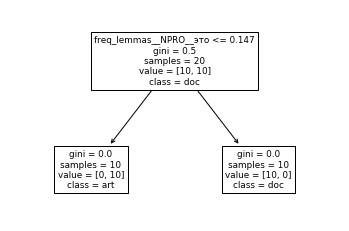

In [29]:
plot_tree(dtree, class_names=['doc','art'], feature_names=X.columns)

# Real data science

In [30]:
import os

In [31]:
sentences_art_full,sentences_doc_full = {}, {}
for fname in os.listdir(DATA_DIR):    
    if fname.startswith('art_'):
        with open(DATA_DIR+fname,'r') as f:
            txt = f.read()
        sentences = get_sentences(txt)
        sentences_art_full[fname[4:-4]] = sentences
    if fname.startswith('doc_'):
        with open(DATA_DIR+fname,'r') as f:
            txt = f.read()
        sentences = get_sentences(txt)
        sentences_doc_full[fname[4:-4]] = sentences

In [32]:
print('art texts:', sentences_art_full.keys())
print('doc texts:', sentences_doc_full.keys())

art texts: dict_keys(['chekchov_joy', 'alice_full_text', 'checkhov_gooseberry', 'strugatskie_god', 'tolstoy_childhood'])
doc texts: dict_keys(['math_importance', 'nplus1', 'nod_master_passport', 'how_to_business_text', 'comp_ling_theory_practise'])


In [33]:
n_sentences_per_text = 70
n_iters = 5000

In [34]:
sentences_art_all = [s for ss in sentences_art_full.values() for s in ss]
sentences_doc_all = [s for ss in sentences_doc_full.values() for s in ss]
print(len(sentences_art_all), len(sentences_doc_all))

3600 404


следующий код выполняется примерно 6 часов

In [35]:
X_doc = pd.read_csv(DATA_DIR+'X_doc.csv', index_col=0)
X_art = pd.read_csv(DATA_DIR+'X_art.csv', index_col=0)

In [36]:
X = pd.concat([X_doc, X_art])
X = X[X.columns[X.isna().mean()<0.5]] #убираем крайне редкие признаки (напр. частые леммы, специфичные для конкретного текста)
X = X.fillna(0)
y = np.concatenate([np.zeros(shape=len(X_doc)), np.ones(shape=len(X_art)) ])
class_names = ['doc','art']
X.shape, y.shape

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


((10000, 113), (10000,))

In [37]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

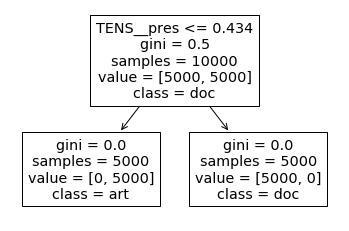

In [38]:
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X,y)
plot_tree(dtree, feature_names=X.columns, class_names=class_names);

Оказывается, художественные и научные тексты можно разделить по всего одному признаку. Найдём ещё похожие признаки

In [39]:
ideal_splits = []
feats_left = list(X.columns)
trees = []
for n_combs in range(1,2):
    for fs in tqdm(combinations(feats_left, n_combs), total=len(list(combinations(feats_left, n_combs))), desc=f'n_combs: {n_combs}'):
        fs = list(fs)
        if any([all([f in fs for f in isplit[0]]) for isplit in ideal_splits]):
            continue
        dtree = DecisionTreeClassifier(max_depth=len(fs))
        dtree.fit(X[fs],y)
        if accuracy_score(y, dtree.predict(X[fs]))==1:
            ideal_splits.append((fs, dtree.tree_.threshold))
            trees.append(dtree)
    feats_left = [f for f in feats_left if f not in set([f_ for f in ideal_splits for f_ in f[0]])]

In [40]:
import pickle

In [41]:
with open('ideal_feats_data.pickle','wb') as f:
    pickle.dump({'ideal_splits':ideal_splits, 'trees':trees}, f)

In [42]:
with open('ideal_feats_data.pickle','rb') as f:
    d = pickle.load(f)
    ideal_splits = d['ideal_splits']
    trees = d['trees']

In [43]:
for idx, isplit in enumerate([x for x in ideal_splits if len(x[0])==1]):
    print(f"{idx+1}: {isplit[0][0]} > {isplit[1][0]:.2f} => {class_names[int(y[X[isplit[0][0]]>isplit[1][0]].mean())]}", )

1: ASP__impf > 0.67 => doc
2: ASP__perf > 0.33 => art
3: CASE__gent > 0.38 => doc
4: PERS__3per > 0.42 => doc
5: PERS__None > 0.50 => art
6: POS__ADJF > 0.15 => doc
7: POS__NOUN > 0.34 => doc
8: POS__NPRO > 0.04 => art
9: POS__VERB > 0.11 => art
10: TENS__past > 0.47 => art
11: TENS__pres > 0.43 => doc
12: n_lemma_uniq__ADJF > 85.00 => doc


Итого:
* В научных текстах много глаголов несовершенного вида, в художественных - совершенного
* В научных текстах часто употребляется родительный падеж
* В научных текстах намного чаще употребляются глаголы в третьем лице
* В художественных текстах анализатор часто не может определить лицо (видимо употребляются более нестандартные формы глаголов)
* В научных тестах сильно больше полных прилагательных и существительных
* В художественных тестах сильно больше "местоимений-существительных" и глаголов
* В художественных текстах часто пишут в прошедшем времени
* В научных текстах часто пишут в настоящем времени
* В научных текстах обычно больше 85 уникальных прилагательных